In [ ]:
ROOT = '/content/gdrive'

In [ ]:

from google.colab import drive
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.18.0'

In [ ]:
!pip install tensorflow_privacy==0.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
import time

from IPython import display

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

In [ ]:

def _random_choice(inputs, n_samples):
    """
    With replacement.
    Params:
      inputs (Tensor): Shape [n_states, n_features]
      n_samples (int): The number of random samples to take.
    Returns:
      sampled_inputs (Tensor): Shape [n_samples, n_features]
    """

    uniform_log_prob = tf.expand_dims(tf.zeros(tf.shape(inputs)[0]), 0)

    ind = tf.compat.v1.multinomial(uniform_log_prob, n_samples)
    ind = tf.squeeze(ind, 0, name="random_choice_ind")

    return tf.gather(inputs, ind, name="random_choice")

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

In [ ]:

def compute_fpr_tpr_roc(Y_test, Y_score):
    n_classes = Y_score.shape[1]
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    for class_cntr in range(n_classes):
        false_positive_rate[class_cntr], true_positive_rate[class_cntr], _ = roc_curve(Y_test[:, class_cntr],
                                                                                       Y_score[:, class_cntr])
        roc_auc[class_cntr] = auc(false_positive_rate[class_cntr], true_positive_rate[class_cntr])


    false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(false_positive_rate["micro"], true_positive_rate["micro"])

    return false_positive_rate, true_positive_rate, roc_auc

In [ ]:
from absl import logging
import collections

from tensorflow_privacy.privacy.analysis import privacy_ledger
from tensorflow_privacy.privacy.dp_query import gaussian_query

def make_optimizer_class(cls):
  """Constructs a DP optimizer class from an existing one."""
  parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
  child_code = cls.compute_gradients.__code__
  GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP
  if child_code is not parent_code:
    logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

  class DPOptimizerClass(cls):
    """Differentially private subclass of given class cls."""

    _GlobalState = collections.namedtuple(
      '_GlobalState', ['l2_norm_clip', 'stddev'])

    def __init__(
        self,
        dp_sum_query,
        num_microbatches=None,
        unroll_microbatches=False,
        *args,
        **kwargs):
      """Initialize the DPOptimizerClass.

      Args:
        dp_sum_query: DPQuery object, specifying differential privacy
          mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
      """
      super(DPOptimizerClass, self).__init__(*args, **kwargs)
      self._dp_sum_query = dp_sum_query
      self._num_microbatches = num_microbatches
      self._global_state = self._dp_sum_query.initial_global_state()

      self._unroll_microbatches = unroll_microbatches

    def compute_gradients(self,
                          loss,
                          var_list,
                          gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False,
                          grad_loss=None,
                          gradient_tape=None,
                          curr_noise_mult=0,
                          curr_norm_clip=1):

      self._dp_sum_query = gaussian_query.GaussianSumQuery(curr_norm_clip,
                                                           curr_norm_clip*curr_noise_mult)
      self._global_state = self._dp_sum_query.make_global_state(curr_norm_clip,
                                                                curr_norm_clip*curr_noise_mult)


      # TF is running in Eager mode, check we received a vanilla tape.
      if not gradient_tape:
        raise ValueError('When in Eager mode, a tape needs to be passed.')

      vector_loss = loss()
      if self._num_microbatches is None:
        self._num_microbatches = tf.shape(input=vector_loss)[0]
      sample_state = self._dp_sum_query.initial_sample_state(var_list)
      microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
      sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

      def process_microbatch(i, sample_state):
        """Process one microbatch (record) with privacy helper."""
        microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
        grads = gradient_tape.gradient(microbatch_loss, var_list)
        sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
        return sample_state

      for idx in range(self._num_microbatches):
        sample_state = process_microbatch(idx, sample_state)

      if curr_noise_mult > 0:
        grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
      else:
        grad_sums = sample_state

      def normalize(v):
        return v / tf.cast(self._num_microbatches, tf.float32)

      final_grads = tf.nest.map_structure(normalize, grad_sums)
      grads_and_vars = final_grads#list(zip(final_grads, var_list))

      return grads_and_vars

  return DPOptimizerClass


def make_gaussian_optimizer_class(cls):
  """Constructs a DP optimizer with Gaussian averaging of updates."""

  class DPGaussianOptimizerClass(make_optimizer_class(cls)):
    """DP subclass of given class cls using Gaussian averaging."""

    def __init__(
        self,
        l2_norm_clip,
        noise_multiplier,
        num_microbatches=None,
        ledger=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
      dp_sum_query = gaussian_query.GaussianSumQuery(
          l2_norm_clip, l2_norm_clip * noise_multiplier)

      if ledger:
        dp_sum_query = privacy_ledger.QueryWithLedger(dp_sum_query,
                                                      ledger=ledger)

      super(DPGaussianOptimizerClass, self).__init__(
          dp_sum_query,
          num_microbatches,
          unroll_microbatches,
          *args,
          **kwargs)

    @property
    def ledger(self):
      return self._dp_sum_query.ledger

  return DPGaussianOptimizerClass

In [ ]:
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
DPGradientDescentGaussianOptimizer_NEW = make_gaussian_optimizer_class(GradientDescentOptimizer)

# **OUTPUT DIRECTORY**

In [ ]:

result_dir = ROOT + '/My Drive/TEST'

In [ ]:

checkpoint_dir = result_dir + '/training_checkpoints'

def checkpoint_name(title):
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt__" + str(title))
  return(checkpoint_prefix)

In [ ]:

images_dir = result_dir + '/images'

def generate_and_save_images(title, model, epoch, test_input, test_label):

  predictions = model([test_input, test_label], training=False)

  fig = plt.figure(figsize=(2,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 1, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(images_dir + '/' + title + '___image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
if not os.path.exists(result_dir):
  os.makedirs(result_dir)

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

if not os.path.exists(images_dir):
  os.makedirs(images_dir)

# **DATASET**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_labels = train_labels.reshape((60000, 1))
COND_num_classes = 10 # Number of classes, set to 10 for MNIST dataset
train_labels_vec = np.zeros((len(train_labels), COND_num_classes), dtype='float32')
for i, label in enumerate(train_labels):
    train_labels_vec[i, int(train_labels[i])] = 1.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-18-078f292e9557>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels_vec[i, int(train_labels[i])] = 1.0


# CGAN **MODEL**

In [ ]:

Z_DIM = 100

In [ ]:
def make_generator_model_FCC():

    in_label = layers.Input(shape=(COND_num_classes,))

    in_lat = layers.Input(shape=(Z_DIM,))

    merge = layers.concatenate([in_lat, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    ge2 = layers.Dense(784, use_bias=True, activation="tanh")(ge1)
    out_layer = layers.Reshape((28, 28, 1))(ge2)

    model = models.Model([in_lat, in_label], out_layer)

    return model

def make_discriminator_model_FCC():

    in_label = layers.Input(shape=(COND_num_classes,))

    in_image = layers.Input(shape=(28, 28, 1))
    in_image_b = layers.Flatten()(in_image)

    merge = layers.concatenate([in_image_b, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    out_layer = layers.Dense(1, use_bias=True)(ge1)

    model = models.Model([in_image, in_label], out_layer)

    return model

In [ ]:
generator = make_generator_model_FCC()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 110)            │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         14,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 784)            │        101,136 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 28, 28, 1)      │              0 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 115,344 (450.56 KB)

 Trainable params: 115,344 (450.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator = make_discriminator_model_FCC()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 794)            │              0 │ flatten[0][0],         │
│ (Concatenate)             │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        101,760 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ re_lu_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,889 (398.00 KB)

 Non-trainable params: 0 (0.00 B)

(1, 100)
(1, 10)
tf.Tensor([[-0.441919]], shape=(1, 1), dtype=float32)


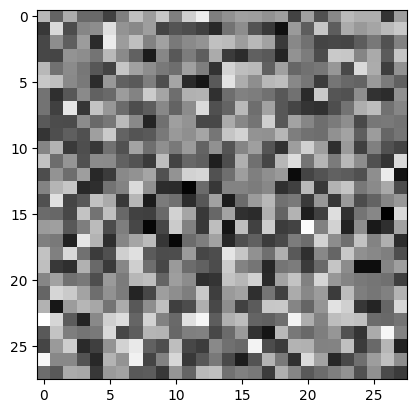

In [ ]:

noise = tf.Variable(tf.random.normal([1, Z_DIM]))
noise_label = tf.Variable(np.array([0,0,1,0,0,0,0,0,0,0], dtype='float32').reshape((1,10)))
print(noise.shape)
print(noise_label.shape)
generated_image = generator([noise, noise_label], training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

decision = discriminator([generated_image, noise_label])
print(decision)

In [ ]:
cross_entropy_DISC = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
cross_entropy_GEN = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step_DISC(images, labels, noise, labels_to_gen):
    with tf.GradientTape(persistent=True) as disc_tape_real:

        dummy = discriminator([images, labels], training=True)
        var_list = discriminator.trainable_variables

        def loss_fn_real():
            real_output = discriminator([images, labels], training=True)
            disc_real_loss = cross_entropy_DISC(tf.ones_like(real_output), real_output)
            return disc_real_loss

        grads_and_vars_real = discriminator_optimizer.compute_gradients(loss_fn_real,
                                                                        var_list,
                                                                        gradient_tape=disc_tape_real,
                                                                        curr_noise_mult=NOISE_MULT,
                                                                        curr_norm_clip=NORM_CLIP)

        # In Eager mode, the optimizer takes a function that returns the loss.
        def loss_fn_fake():
            generated_images = generator([noise, labels_to_gen], training=True)
            fake_output = discriminator([generated_images, labels_to_gen], training=True)
            disc_fake_loss = cross_entropy_DISC(tf.zeros_like(fake_output), fake_output)
            return disc_fake_loss

        grads_and_vars_fake = discriminator_optimizer.compute_gradients(loss_fn_fake,
                                                                        var_list,
                                                                        gradient_tape=disc_tape_real,
                                                                        curr_noise_mult=0,
                                                                        curr_norm_clip=NORM_CLIP)
        disc_loss_r = loss_fn_real()
        disc_loss_f = loss_fn_fake()

        s_grads_and_vars = [(grads_and_vars_real[idx] + grads_and_vars_fake[idx])
                            for idx in range(len(grads_and_vars_real))]
        sanitized_grads_and_vars = list(zip(s_grads_and_vars, var_list))

        discriminator_optimizer.apply_gradients(sanitized_grads_and_vars)

    return(disc_loss_r, disc_loss_f)


@tf.function
def train_step_GEN(labels, noise):
    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        # if the generator is performing well, the discriminator will classify the fake images as real (or 1)
        gen_loss = cross_entropy_GEN(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return(gen_loss)

In [ ]:
def train(dataset, title, verbose):
    for epoch in range(EPOCHS):
        start = time.time()

        i_gen = 0
        for image_batch, label_batch in dataset:
            if verbose:
                print("Iteration: " + str(i_gen+1))

            noise = tf.random.normal([BATCH_SIZE, Z_DIM])
            labels_to_gen = _random_choice(labels_gen_vec, BATCH_SIZE)

            d_loss_r, d_loss_f = train_step_DISC(image_batch, label_batch, noise, labels_to_gen)
            if verbose:
                print("Loss DISC Real: " + str(tf.reduce_mean(d_loss_r)))
                print("Loss DISC Fake: " + str(tf.reduce_mean(d_loss_f)))

            if (i_gen + 1) % N_DISC == 0:
                g_loss_f = train_step_GEN(labels_to_gen, noise)
                if verbose:
                    print("Loss GEN Fake:: " + str(g_loss_f))

            i_gen = i_gen + 1

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(title,
                                 generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Save the model
        checkpoint.save(file_prefix = checkpoint_name(title + "__epoch=" + str(epoch) + "__"))

# **PARAMETERS**

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 600
NR_MICROBATCHES = 600

NORM_CLIP = 1.1
NOISE_MULT = 1.15

DP_DELTA = 1e-5
EPOCHS = 250

N_DISC = 1

# Learning Rate for DISCRIMINATOR
LR_DISC = tf.compat.v1.train.polynomial_decay(
    learning_rate=0.150,
    global_step=tf.compat.v1.train.get_or_create_global_step(),
    decay_steps=10000,
    end_learning_rate=0.052,
    power=1
)

if BATCH_SIZE % NR_MICROBATCHES != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Calculate EPSILON based on differential privacy parameters
EPSILON = (NOISE_MULT * NORM_CLIP) / (NR_MICROBATCHES * DP_DELTA)


In [ ]:
# Obtain DP_EPSILON
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n = BUFFER_SIZE,
                                              batch_size = BATCH_SIZE,
                                              noise_multiplier = NOISE_MULT,
                                              epochs = EPOCHS,
                                              delta = DP_DELTA)

DP-SGD with sampling rate = 1% and noise_multiplier = 1.15 iterated over 25000 steps satisfies differential privacy with eps = 9.66 and delta = 1e-05.
The optimal RDP order is 3.5.


(9.664938893002677, 3.5)

In [ ]:

NOISE_MULT*NORM_CLIP

1.265

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam()

discriminator_optimizer = DPGradientDescentGaussianOptimizer_NEW(
   learning_rate = LR_DISC,
   l2_norm_clip = NORM_CLIP,
   noise_multiplier = NOISE_MULT,
   num_microbatches = NR_MICROBATCHES)

# **TRAINING**

In [ ]:

generator = make_generator_model_FCC()
discriminator = make_discriminator_model_FCC()

In [ ]:

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
tf.random.set_seed(1)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels_vec)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

seed = tf.random.normal([10, Z_DIM])
seed_labels = tf.Variable(np.diag(np.full(10,1)).reshape((10,10)), dtype='float32')

labels_gen_vec = np.zeros((10, COND_num_classes), dtype='float32')
for i in [0,1,2,3,4,5,6,7,8,9]:
  labels_gen_vec[i, int(i)] = 1.0

In [ ]:

training_title = 'NNNN'

In [ ]:
train(train_dataset, training_title, False)

AttributeError: in user code:

    File "<ipython-input-24-c4e8e1262ab6>", line 41, in train_step_DISC  *
        discriminator_optimizer.apply_gradients(sanitized_grads_and_vars)

    AttributeError: 'Variable' object has no attribute '_in_graph_mode'


# **VALIDATION**

In [ ]:

title = training_title
epoch_ckp = EPOCHS - 1

In [ ]:

checkpoint_name = checkpoint_dir + "/ckpt__" + str(title) + "__epoch=" + str(epoch_ckp) + "__-" + str(EPOCHS)

checkpoint.restore(checkpoint_name)

In [ ]:
# Number of images to generate
N_GEN = 5000

In [ ]:
N_GEN_per_CLASS = int(N_GEN/10)

tf.random.set_seed(10)
noise_GEN = tf.random.normal([N_GEN, Z_DIM])
labels_GEN = tf.Variable(np.array([1,0,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,1,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,1,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,1,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,1,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,1,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,1,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,1,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,1,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,0,1]*N_GEN_per_CLASS,
                                   dtype='float32').reshape((N_GEN,10)))

In [ ]:
images_GEN = generator([noise_GEN, labels_GEN], training=False)
images_flat = layers.Flatten()(images_GEN)

In [ ]:
labels_flat = tf.Variable(np.array([0]*N_GEN_per_CLASS +
                                   [1]*N_GEN_per_CLASS +
                                   [2]*N_GEN_per_CLASS +
                                   [3]*N_GEN_per_CLASS +
                                   [4]*N_GEN_per_CLASS +
                                   [5]*N_GEN_per_CLASS +
                                   [6]*N_GEN_per_CLASS +
                                   [7]*N_GEN_per_CLASS +
                                   [8]*N_GEN_per_CLASS +
                                   [9]*N_GEN_per_CLASS,
                                   dtype='float32').reshape((N_GEN,1)))

In [ ]:
Y_train = labels_flat[:images_flat.shape[0]]
X_train = images_flat

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_train_org = label_binarize(Y_train, classes=classes)
Y_train_vec = layers.Flatten()(Y_train_org)

## VALIDATION *RESULTS*

In [ ]:


tf.random.set_seed(100)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))
NN_model = classifier_NN.fit(X_train, Y_train)

In [ ]:
# ROC per class: Validating on REAL training dataset
Y_score = NN_model.predict_proba(train_images.reshape(60000,28*28*1))
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(train_labels_vec), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

In [ ]:


tf.random.set_seed(100)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs',
                                                       multi_class='multinomial',
                                                       random_state=2))
LR_model = classifier_LR.fit(X_train, Y_train)

In [ ]:
# ROC per class: Validating on REAL training dataset
Y_score = LR_model.predict_proba(train_images.reshape(60000,28*28*1))
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(train_labels_vec), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]




# **TESTING**

In [ ]:
(_, _), (X_test_org, Y_test_org) = tf.keras.datasets.mnist.load_data()

X_test_org = X_test_org.reshape(X_test_org.shape[0], 28, 28, 1).astype('float32')
X_test_org = (X_test_org - 127.5) / 127.5 # Normalize the images to [-1, 1]

Y_test_org = [int(y) for y in Y_test_org]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_test_org = label_binarize(Y_test_org, classes=classes)

X_test = layers.Flatten()(X_test_org)
Y_test = layers.Flatten()(Y_test_org)

# Vanilla Neural *Network*

In [ ]:


tf.random.set_seed(1)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))
NN_model2 = classifier_NN.fit(X_train, Y_train)

In [ ]:
# ROC per class on the test dataset
Y_score = NN_model2.predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Function to compute FPR, TPR, and ROC AUC for each class
def compute_fpr_tpr_roc(true_labels, predicted_probs):
    n_classes = predicted_probs.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

# Assuming Y_test and Y_score are available
Y_score = NN_model2.predict_proba(X_test)

# Assuming Y_test is one-hot encoded
Y_test_one_hot = label_binarize(np.argmax(Y_test, axis=1), classes=np.arange(len(classes)))

# ROC per class
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(Y_test_one_hot, Y_score)

# Print AUC for each class
print("\nAUC for each class:")
print([str(au) + " = " + str(roc_auc[au]) for au in roc_auc])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label='Class {}: AUC={:.2f}'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend()
plt.show()




In [ ]:
# Compute and display confusion matrix
predicted_labels = np.argmax(Y_score, axis=1)
true_labels = np.argmax(Y_test, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Logistic *Regression*

In [ ]:
#####

tf.random.set_seed(1)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs',
                                                       multi_class='multinomial',
                                                       random_state=2))
LR_model2 = classifier_LR.fit(X_train, Y_train)

In [ ]:
# ROC per class
Y_score = LR_model2.predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label='Class {}: AUC={:.2f}'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend()
plt.show()


In [ ]:

# Predictions
Y_pred_LR = LR_model2.predict(X_test)
num_classes=10
# Assuming Y_test and Y_pred_LR are NumPy arrays
Y_test_np_LR = Y_test_org.numpy() if hasattr(Y_test_org, 'numpy') else Y_test_org
Y_test_bin_LR = label_binarize(np.argmax(Y_test_np_LR, axis=1), classes=range(num_classes))
Y_pred_bin_LR = label_binarize(Y_pred_LR, classes=range(num_classes))





In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Calculate confusion matrix
conf_matrix_LR = confusion_matrix(Y_test_bin_LR.argmax(axis=1), Y_pred_bin_LR.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_LR, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Predictions
Y_pred_LR = LR_model2.predict(X_test)
num_classes=10
# Assuming Y_test and Y_pred_LR are NumPy arrays
Y_test_np_LR = Y_test_org.numpy() if hasattr(Y_test_org, 'numpy') else Y_test_org
Y_test_bin_LR = label_binarize(np.argmax(Y_test_np_LR, axis=1), classes=range(num_classes))
Y_pred_bin_LR = label_binarize(Y_pred_LR, classes=range(num_classes))

# Calculate accuracy, precision, and F1 score
accuracy_LR = accuracy_score(Y_test_bin_LR, Y_pred_bin_LR)
precision_LR = precision_score(Y_test_bin_LR, Y_pred_bin_LR, average='weighted')
f1_LR = f1_score(Y_test_bin_LR, Y_pred_bin_LR, average='weighted')

# Print the results
print("Logistic Regression Model:")
print("Accuracy:", accuracy_LR)
print("Precision:", precision_LR)
print("F1 Score:", f1_LR)


Y_test_bin = label_binarize(np.argmax(Y_test_np_LR, axis=1), classes=range(num_classes))
# Assuming Y_test_bin_LR is already defined from the logistic regression model evaluation
Y_pred_bin = label_binarize(np.random.randint(0, 2, size=(len(Y_test_bin_LR),)), classes=[0, 1])



# Calculate precision, accuracy, and F1 score
precision = precision_score(Y_test_bin.argmax(axis=1), Y_pred_bin.argmax(axis=1), average='weighted')
accuracy = accuracy_score(Y_test_bin.argmax(axis=1), Y_pred_bin.argmax(axis=1))
f1 = f1_score(Y_test_bin.argmax(axis=1), Y_pred_bin.argmax(axis=1), average='weighted')

# Plotting
metrics = ['Precision', 'Accuracy', 'F1 Score']
values = [precision, accuracy, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.0)  # Assuming scores are between 0 and 1
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# Calculate confusion matrix
conf_matrix_LR = confusion_matrix(Y_test_bin_LR.argmax(axis=1), Y_pred_bin_LR.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_LR, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Perform clustering
kmeans = KMeans(n_clusters=2)  # Assuming 2 clusters for simplicity
clusters = kmeans.fit_predict(X_test)  # Assuming X_test contains the data used for clustering

# Define thresholds and assign labels
# Example: Assuming clusters are classified based on cluster size or density
threshold = 100  # Adjust as needed
cluster_sizes = np.bincount(clusters)
cluster_labels = ['Non-Differentially Private' if size > threshold else 'Differentially Private' for size in cluster_sizes]

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Classification into differentially private and non-differentially private
# Example: Assuming clusters are classified based on cluster size or density
differentially_private_clusters = [cluster for cluster, label in zip(clusters, cluster_labels) if label == 'Differentially Private']
non_differentially_private_clusters = [cluster for cluster, label in zip(clusters, cluster_labels) if label == 'Non-Differentially Private']

print("Differentially Private Clusters:", len(differentially_private_clusters))
print("Non-Differentially Private Clusters:", len(non_differentially_private_clusters))

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering
kmeans = KMeans(n_clusters=2)  # Assuming 2 clusters for simplicity
clusters = kmeans.fit_predict(X_test)  # Assuming X_test contains the data used for clustering

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define thresholds and assign labels
# Example: Assuming clusters are classified based on cluster size or density
threshold = 100  # Adjust as needed
cluster_labels = ['Non-Differentially Private' if np.sum(clusters == label) > threshold else 'Differentially Private' for label in unique_clusters]

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Classification into differentially private and non-differentially private
# Example: Assuming clusters are classified based on cluster size or density
differentially_private_clusters = [label for label, label_name in zip(unique_clusters, cluster_labels) if label_name == 'Differentially Private']
non_differentially_private_clusters = [label for label, label_name in zip(unique_clusters, cluster_labels) if label_name == 'Non-Differentially Private']

print("Differentially Private Clusters:", len(differentially_private_clusters))
print("Non-Differentially Private Clusters:", len(non_differentially_private_clusters))


In [ ]:
cluster_sizes = [(clusters == i).sum() for i in range(len(np.unique(clusters)))]

# Define thresholds and assign labels
threshold = 100  # Adjust as needed
cluster_labels = ['Non-Differentially Private' if size > threshold else 'Differentially Private' for size in cluster_sizes]

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Classification into differentially private and non-differentially private
differentially_private_clusters = [i for i, label in enumerate(cluster_labels) if label == 'Differentially Private']
non_differentially_private_clusters = [i for i, label in enumerate(cluster_labels) if label == 'Non-Differentially Private']

print("Differentially Private Clusters:", len(differentially_private_clusters))
print("Non-Differentially Private Clusters:", len(non_differentially_private_clusters))

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering
kmeans = KMeans(n_clusters=2)  # Assuming 2 clusters for simplicity
clusters = kmeans.fit_predict(X_test)  # Assuming X_test contains the data used for clustering

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define thresholds and assign labels
# Example: Assuming clusters are classified based on cluster size or density
threshold = 100  # Adjust as needed
cluster_labels = ['Non-Differentially Private' if np.sum(clusters == label) > threshold else 'Differentially Private' for label in unique_clusters]

# Classification into differentially private and non-differentially private
# Example: Assuming clusters are classified based on cluster size or density
data_labels = ['Non-Differentially Private' if label == 0 else 'Differentially Private' for label in clusters]

print("Data Labels:")
print(data_labels)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have X_test and clusters already defined

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define thresholds and assign labels
threshold = 100  # Adjust as needed
cluster_labels = ['Non-Differentially Private' if np.sum(clusters == label) > threshold else 'Differentially Private' for label in unique_clusters]

# Classification into differentially private and non-differentially private
data_labels = ['Non-Differentially Private' if label == 0 else 'Differentially Private' for label in clusters]

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Add cluster labels to the plot
for i, txt in enumerate(cluster_labels):
    plt.annotate(txt, (X_test[i, 0], X_test[i, 1]), xytext=(5, -5), textcoords='offset points')

plt.show()

print("Data Labels:")
print(data_labels)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have X_test and clusters already defined

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define thresholds and assign labels
threshold = 100  # Adjust as needed
cluster_labels = ['Non-Differentially Private' if np.sum(clusters == label) > threshold else 'Differentially Private' for label in unique_clusters]

# Classification into differentially private and non-differentially private
data_labels = ['Non-Differentially Private' if label == 0 else 'Differentially Private' for label in clusters]

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Add cluster labels to the plot
for i, txt in enumerate(cluster_labels):
    plt.annotate(txt, (X_test[i, 0], X_test[i, 1]), xytext=(5, -5), textcoords='offset points')

plt.show()

print("Data Labels:")
print(data_labels)


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Add cluster labels to the plot
for i, txt in enumerate(cluster_labels):
    plt.annotate(txt, (X_test[i, 0], X_test[i, 1]), xytext=(5, -5), textcoords='offset points')

plt.show()

# Print data labels
print("Data Labels:")
print(data_labels)

# Get paths to all image files in a folder
folder_path = '/content/gdrive/MyDrive/TEST/images'  # Update with the path to your folder
image_paths = glob.glob(os.path.join(folder_path, '*.png'))  # Assuming all images are in PNG format
print("Number of image files found:", len(image_paths))
print("Image paths:")
print(image_paths)

# Plot images with labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(image_paths):  # Ensure that we don't try to access a non-existent index
        img = mpimg.imread(image_paths[i])
        ax.imshow(img)
        ax.set_title(data_labels[i])  # Set title as the classification label
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Count the number of images in each class
num_non_dp_images = data_labels.count('Non-Differentially Private')
num_dp_images = data_labels.count('Differentially Private')

print("Number of Non-Differentially Private Images:", num_non_dp_images)
print("Number of Differentially Private Images:", num_dp_images)


In [ ]:
from collections import Counter

# Assuming you already have 'clusters' variable containing cluster labels

# Count the number of images in each cluster
cluster_counts = Counter(clusters)

# Print the number of images in each cluster
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} images")


In [ ]:
from collections import Counter

# Assuming you already have 'clusters' variable containing cluster labels

# Count the number of images in each cluster
cluster_counts = Counter(clusters)

# Print the number of images in each cluster
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} images")

# Plot clustering graph
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from collections import Counter

# Assuming you already have 'clusters' variable containing cluster labels

# Convert X_test to a NumPy array
X_test_np = X_test.numpy()

# Count the number of images in each cluster
cluster_counts = Counter(clusters)

# Print the number of images in each cluster
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} images")

# Plot clustering graph
plt.figure(figsize=(12, 10))  # Increase the figure size
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

# Zoom in
plt.xlim(X_test_np[:, 0].min() - 0.1, X_test_np[:, 0].max() + 0.1)
plt.ylim(X_test_np[:, 1].min() - 0.1, X_test_np[:, 1].max() + 0.1)

plt.show()


In [ ]:
from collections import Counter

# Assuming you already have 'clusters' variable containing cluster labels

# Convert X_test to a NumPy array
X_test_np = X_test.numpy()

# Count the number of images in each cluster
cluster_counts = Counter(clusters)

# Print the number of images in each cluster
for cluster_label, count in cluster_counts.items():
    print(f"Cluster {cluster_label}: {count} images")

# Plot clustering graph
plt.figure(figsize=(12, 10))  # Increase the figure size

for cluster_label in np.unique(clusters):
    plt.plot(X_test_np[clusters == cluster_label][:, 0], X_test_np[clusters == cluster_label][:, 1], 'o-', label=f'Cluster {cluster_label}')

plt.title('Clustering Graph')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
